##  Importing Dependencies
   We shall start by importing all the neccessary libraries. I will explain the exact use of each library later in this notebook.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


import re

print("Tensorflow Version",tf.__version__)

Tensorflow Version 2.12.0


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
!unzip

In [2]:
df = pd.read_csv('/content/training.1600000.processed.noemoticon.csv.zip',
                 encoding = 'latin',header=None)
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [3]:
b=[10,20,15,30]
for i in range(len(b)-1):
  for j in range(i,len(b)):
        if b[j]>b[i+1] and b[i]>b[i-1]:
          print(b[i])
        elif b[i] >b[i-1]:
          print(b[i])
        elif b[i]>b[i+1]:
          print(b[i])


20
20
20


You can see the columns are without any proper names. Lets rename them for our reference

In [4]:
df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
df.head()

,sentiment,id,date,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


We are going to train only on text to classify its sentiment. So we can ditch the rest of the useless columns.

In [5]:
df = df.drop(['id', 'date', 'query', 'user_id'], axis=1)

In [6]:
lab_to_sentiment = {0:"Negative", 4:"Positive"}
def label_decoder(label):
  return lab_to_sentiment[label]
df.sentiment = df.sentiment.apply(lambda x: label_decoder(x))
df.head()

,sentiment,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."


Here are decoding the labels. We map **0 -> Negative and 1 -> Positive** as directed by the datset desciption. Now that we decoded we shall now analyse the dataset by its distribution. Because it's important that we have almost small amount of examples for given classes.

Text(0.5, 1.0, 'Sentiment Data Distribution')

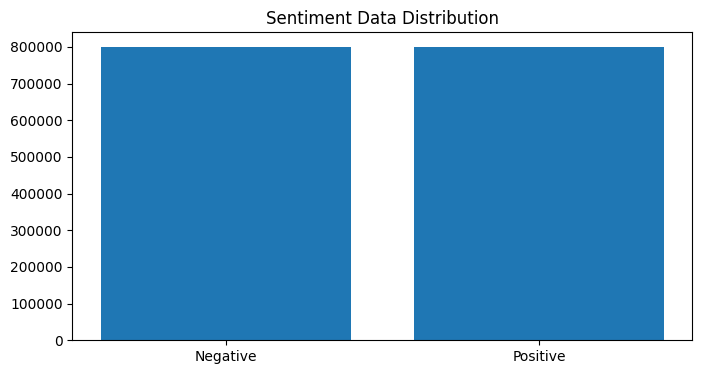

In [7]:
val_count = df.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

It's a very good dataset without any skewness. Thank Goodness.

Now let us explore the data we having here...

In [8]:
import random
random_idx_list = [random.randint(1,len(df.text)) for i in range(10)] # creates random indexes to choose from dataframe
df.loc[random_idx_list,:].head(5) # Returns the rows with the index and display it

,sentiment,text
1296490,Positive,MSNBC. Thank you for calling my cell. today j...
769203,Negative,@ryannajuch y'all never invite me
1247249,Positive,PGA Tour Player- Ricky Barnes visits Wilson Go...
238797,Negative,experienced toothache d whole day
641994,Negative,fuck it sucks not having a job


In [9]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [10]:
def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [11]:
df.text = df.text.apply(lambda x: preprocess(x))

**Aaww.. It is clean and tidy now. Now let's see some word cloud visualizations of it.**

### Positive Words

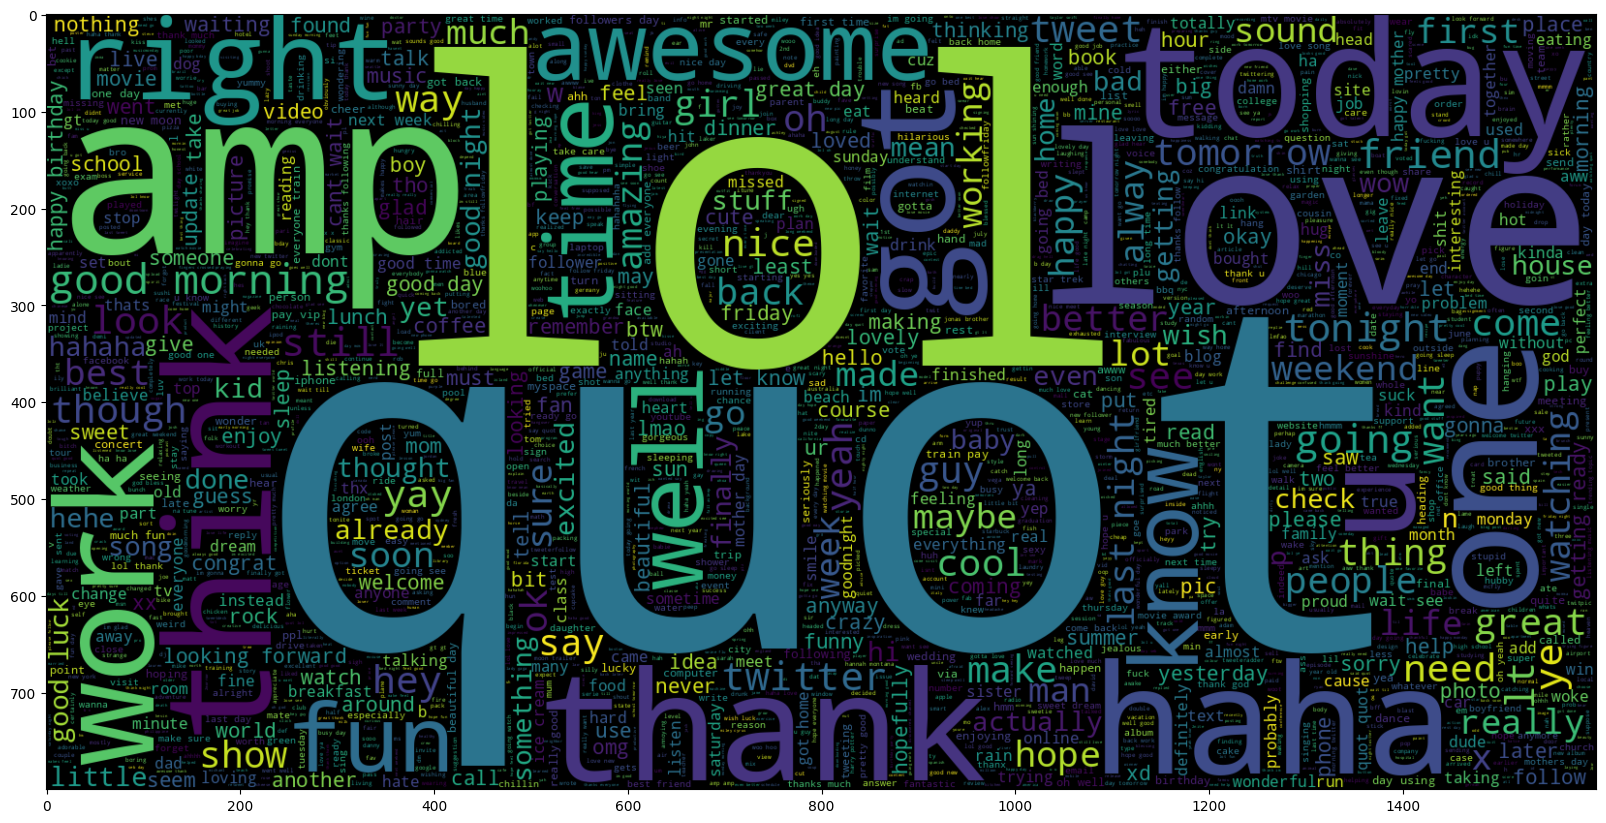

In [12]:
from wordcloud import WordCloud

plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'Positive'].text))
plt.imshow(wc , interpolation = 'bilinear')

### Negative Words

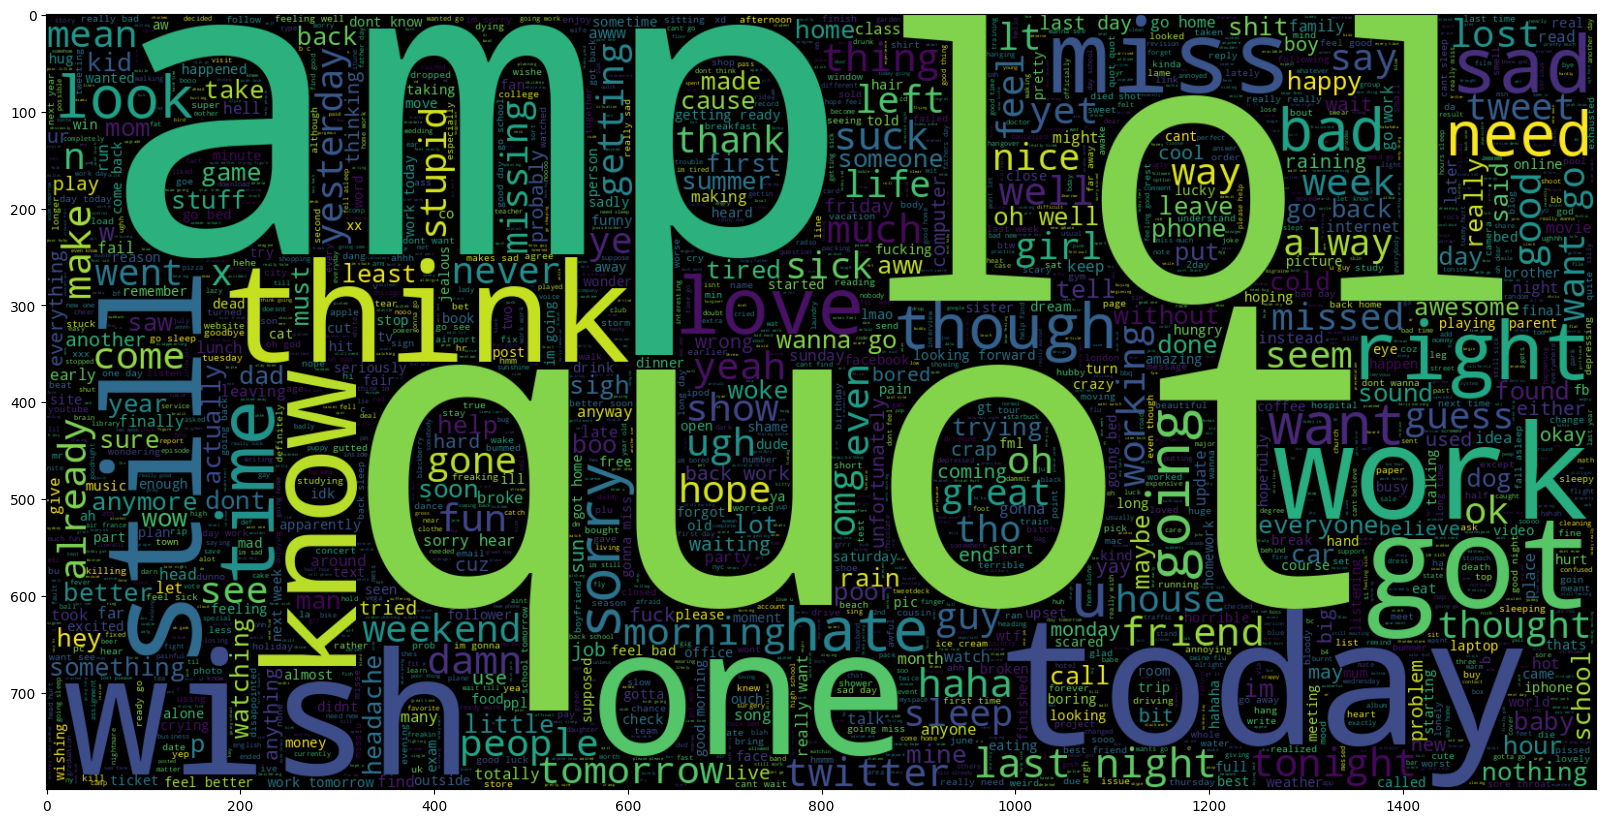

In [13]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'Negative'].text))
plt.imshow(wc , interpolation = 'bilinear')

## Train and Test Split

In [14]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30

In [15]:
train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE,
                                         random_state=7) # Splits Dataset into Training and Testing set
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 1280000
Test Data size 320000


`train_test_split` will shuffle the dataset and split it to gives training and testing dataset. It's important to shuffle our dataset before training.

In [16]:
train_data.head(10)

,sentiment,text
23786,Negative,need friends
182699,Negative,im trying call impossible
476661,Negative,good pace going 3k 13 min missed 5k turn ended...
1181490,Positive,u gonna shows ny soon luv see u live
878773,Positive,hell yea get em tattoos ink free wish parents ...
130866,Negative,yeah need 2 see ur mom calls back first rememb...
1235876,Positive,sounds like cup tea sign
717314,Negative,tired want sleep wtf
969880,Positive,amazing wish
748698,Negative,thank god wkrn abc affiliate nashville back mi...


In [17]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 290575


In [18]:
!pip install pad_sequences

  Preparing metadata (setup.py) ... done
  Created wheel for pad_sequences: filename=pad_sequences-0.6.1-py3-none-any.whl size=10199 sha256=f436a6991c609899917dd75fe1b46d2a76decb03793f2627f13107d3e33acd95
  Stored in directory: /root/.cache/pip/wheels/48/9d/22/0a6305b87a9cc46ccc032060a041c3b59f39ac462f7358997e
Successfully built pad_sequences


In [19]:
from keras.utils import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (1280000, 30)
Testing X Shape: (320000, 30)


In [20]:
labels = train_data.sentiment.unique().tolist()

### Label Encoding
We are building the model to predict class in enocoded form (0 or 1 as this is a binary classification). We should encode our training labels to encodings.

In [21]:
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1280000, 1)
y_test shape: (320000, 1)


In [22]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2023-09-02 05:18:23--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-09-02 05:18:24--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-09-02 05:18:24--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [23]:
GLOVE_EMB = '/content/glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10
MODEL_PATH = '/content/best_model.hdf5'

In [24]:
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [25]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [26]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

# Model Training - LSTM
We are clear to build our Deep Learning model. While developing a DL model, we should keep in mind of key things like Model Architecture, Hyperparmeter Tuning and Performance of the model.

As you can see in the word cloud, the some words are predominantly feature in both Positive and Negative tweets. This could be a problem if we are using a Machine Learning model like Naive Bayes, SVD, etc.. That's why we use **Sequence Models**.

### Sequence Model
![Sequence Model](https://miro.medium.com/max/1458/1*SICYykT7ybua1gVJDNlajw.png)

Reccurent Neural Networks can handle a seqence of data and learn a pattern of input seqence to give either sequence or scalar value as output. In our case, the Neural Network outputs a scalar value prediction.

For model architecture, we use

1) **Embedding Layer** - Generates Embedding Vector for each input sequence.

2) **Conv1D Layer** - Its using to convolve data into smaller feature vectors.

3) **LSTM** - Long Short Term Memory, its a variant of RNN which has memory state cell to learn the context of words which are at further along the text to carry contextual meaning rather than just neighbouring words as in case of RNN.

4) **Dense** - Fully Connected Layers for classification


In [27]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

In [28]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

### Optimization Algorithm
This notebook uses Adam, optimization algorithm for Gradient Descent. You can learn more about Adam [here](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)

### Callbacks
Callbacks are special functions which are called at the end of an epoch. We can use any functions to perform specific operation after each epoch. I used two callbacks here,

- **LRScheduler** - It changes a Learning Rate at specfic epoch to achieve more improved result. In this notebook, the learning rate exponentionally decreases after remaining same for first 10 Epoch.

- **ModelCheckPoint** - It saves best model while training based on some metrics. Here, it saves the model with minimum Validity Loss.

In [29]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

Let's start training... It takes a heck of a time if training in CPU, be sure your GPU turned on... May the CUDA Cores be with you....

In [30]:
print("Training on GPU...") if tf.test.is_gpu_available() else print("Training on CPU...")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Training on GPU...


In [31]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

Epoch 1/10
1250/1250 [==============================] - 148s 105ms/step - loss: 0.5186 - accuracy: 0.7397 - val_loss: 0.4816 - val_accuracy: 0.7662 - lr: 0.0010
Epoch 2/10
1250/1250 [==============================] - 131s 104ms/step - loss: 0.4884 - accuracy: 0.7619 - val_loss: 0.4725 - val_accuracy: 0.7721 - lr: 0.0010
Epoch 3/10
1250/1250 [==============================] - 136s 109ms/step - loss: 0.4777 - accuracy: 0.7689 - val_loss: 0.4668 - val_accuracy: 0.7753 - lr: 0.0010
Epoch 4/10
1250/1250 [==============================] - 132s 105ms/step - loss: 0.4716 - accuracy: 0.7728 - val_loss: 0.4636 - val_accuracy: 0.7777 - lr: 0.0010
Epoch 5/10
1250/1250 [==============================] - 131s 105ms/step - loss: 0.4674 - accuracy: 0.7754 - val_loss: 0.4622 - val_accuracy: 0.7785 - lr: 0.0010
Epoch 6/10
1250/1250 [==============================] - 130s 104ms/step - loss: 0.4637 - accuracy: 0.7774 - val_loss: 0.4647 - val_accuracy: 0.7773 - lr: 0.0010
Epoch 7/10
1250/1250 [============

# Model Evaluation
Now that we have trained the model, we can evaluate its performance. We will some evaluation metrics and techniques to test the model.

Let's start with the Learning Curve of loss and accuracy of the model on each epoch.

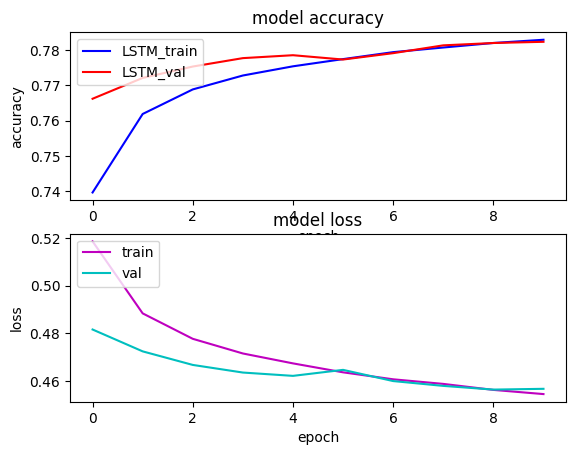

In [32]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

The model will output a prediction score between 0 and 1. We can classify two classes by defining a threshold value for it. In our case, I have set 0.5 as THRESHOLD value, if the score above it. Then it will be classified as **POSITIVE** sentiment.

In [33]:
def decode_sentiment(score):
    return "Positive" if score>0.5 else "Negative"


scores = model.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

32/32 [==============================] - 3s 65ms/step


In [37]:
y_pred_1d

['Negative',
 'Negative',
 'Negative',
 'Negative',
 'Positive',
 'Negative',
 'Positive',
 'Negative',
 'Negative',
 'Positive',
 'Negative',
 'Positive',
 'Negative',
 'Negative',
 'Negative',
 'Positive',
 'Negative',
 'Positive',
 'Positive',
 'Negative',
 'Positive',
 'Negative',
 'Positive',
 'Negative',
 'Negative',
 'Positive',
 'Negative',
 'Positive',
 'Negative',
 'Negative',
 'Positive',
 'Negative',
 'Positive',
 'Negative',
 'Negative',
 'Positive',
 'Negative',
 'Negative',
 'Positive',
 'Negative',
 'Negative',
 'Negative',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Positive',
 'Negative',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Negative',
 'Positive',
 'Negative',
 'Positive',
 'Positive',
 'Negative',
 'Negative',
 'Positive',
 'Positive',
 'Negative',
 'Negative',
 'Negative',
 'Positive',
 'Negative',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Negative',

### Confusion Matrix
Confusion Matrix provide a nice overlook at the model's performance in classification task

In [34]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

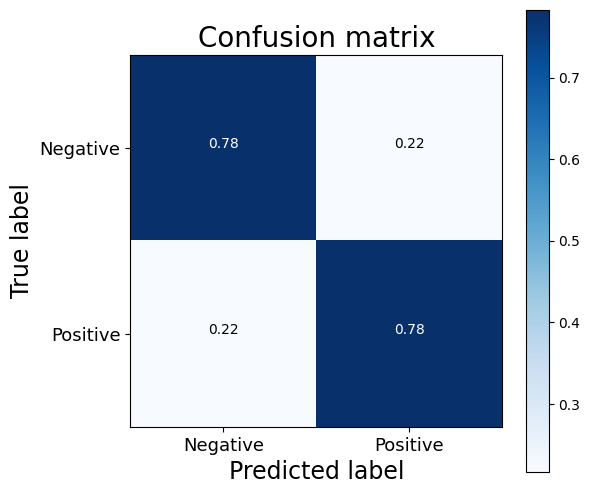

In [35]:
cnf_matrix = confusion_matrix(test_data.sentiment.to_list(), y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=test_data.sentiment.unique(), title="Confusion matrix")
plt.show()

### Classification Scores

In [36]:
print(classification_report(list(test_data.sentiment), y_pred_1d))

              precision    recall  f1-score   support

    Negative       0.78      0.78      0.78    160542
    Positive       0.78      0.78      0.78    159458

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



It's a pretty good model we trained here in terms of NLP. Around 80% accuracy is good enough considering the baseline human accuracy also pretty low in these tasks. Also, you may go on and explore the dataset, some tweets might have other languages than English. So our Embedding and Tokenizing wont have effect on them. But on practical scenario, this model is good for handling most tasks for Sentiment Analysis.